In [1]:
import sys
import os
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
source_dir = Path('/mnt/sandbox/projects/noaa_adapt/data/airsim/source/airsim_simulator/images/')
gt_file = '/mnt/sandbox/projects/noaa_adapt/data/airsim/source/airsim_simulator/airsim_rec.txt'
save_dir = '/mnt/sandbox/projects/noaa_adapt/data/airsim/corrected_dataset/'

In [4]:
gtdf = pd.read_csv(gt_file, sep='\t')

## Extract frames for train / val

In [19]:
def mkdir_if_dne(path):
    if not os.path.exists(str(path)):
        os.mkdir(str(path))

export_chips = False

window_size = 500
half_win = int(window_size / 2)

size = (1920, 1080) # w, h

# Size of step for moving window through dataset
step_size = 250
split = .8
chip_id = 0

label_map = {
            'ground' : 0,
            'sky'    : 1,
            'trees'  : 2,
            'ignore' : 255
            }

label_counts = {i : 0 for i in range(len(label_map))}
label_counts[255] = 0

save_dir = Path('/mnt/sandbox/projects/noaa_adapt/data/airsim/')

mkdir_if_dne(save_dir.joinpath('train'))
mkdir_if_dne(save_dir.joinpath('train/images'))
mkdir_if_dne(save_dir.joinpath('train/labels'))

mkdir_if_dne(save_dir.joinpath('val'))
mkdir_if_dne(save_dir.joinpath('val/images'))
mkdir_if_dne(save_dir.joinpath('val/labels'))

chip_id = 0

for index, row in gtdf.iterrows():
    
    if index < len(gtdf)*split:
        mode = 'train'
    else:
        mode = 'val'
    
    timestamp = row.TimeStamp
    raw_filename, depth_filename, gt_filename = row.ImageFile.split(';')
        
    im = cv2.imread(str(source_dir.joinpath(raw_filename)))
    gt = cv2.imread(str(source_dir.joinpath(gt_filename)))

    label_id_img = np.ones(np.shape(im)) * label_map['trees']
    
    sky_mask = [np.all(pixel == [57, 181,  55]) for pixel in gt.reshape(-1, gt.shape[2])]
    sky_mask = np.array(sky_mask).reshape(gt.shape[:2])
    label_id_img[sky_mask] = label_map['sky']

    ground_mask = [np.all(pixel == [204, 102, 203]) or np.all(pixel == [156,  70, 187]) or np.all(pixel == [163, 193, 118]) or np.all(pixel == [156,  70, 187]) for pixel in gt.reshape(-1, gt.shape[2])]
    ground_mask = np.array(ground_mask).reshape(gt.shape[:2])
    label_id_img[ground_mask] = label_map['ground']
    
    ignore_mask = [np.all(pixel == [156,  70, 187]) for pixel in gt.reshape(-1, gt.shape[2])]
    ignore_mask = np.array(ignore_mask).reshape(gt.shape[:2])
    label_id_img[ignore_mask] = label_map['ignore']
    
    for rr in range(step_size, size[1], step_size):
        for cc in range(step_size, size[0], step_size):
            img_chip = im[rr - half_win : rr + half_win, 
                           cc - half_win : cc + half_win, 
                           :]

            label_id_img_chip = label_id_img[rr - half_win : rr + half_win, 
                                             cc - half_win : cc + half_win, 
                                             ]

            labels, counts = np.unique(label_id_img_chip, return_counts=True)
            for label,count in zip(labels, counts):
                label_counts[int(label)] += count

            img_save_path = '{}/{}/images/{}_{}.png'.format(save_dir, mode, timestamp, str(chip_id).zfill(6))
            label_id_img_save_path = '{}/{}/labels/{}_{}.png'.format(save_dir, mode, timestamp, str(chip_id).zfill(6))
            cv2.imwrite(img_save_path, img_chip)
            cv2.imwrite(label_id_img_save_path, np.uint8(label_id_img_chip))

            chip_id += 1

In [21]:
label_counts
#{0: 6580165497, 1: 1090399812, 2: 3756072921, 3: 0, 255: 139254570}

{0: 6580165497, 1: 1090399812, 2: 3756072921, 3: 0, 255: 139254570}

## Export raw and label frames to disk for visualization

In [6]:
save_path = Path('/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/')

pixel_colors = []

for index, row in gtdf.iterrows():
    timestamp = row.TimeStamp
    raw_filename, depth_filename, gt_filename = row.ImageFile.split(';')

    im = cv2.imread(str(source_dir.joinpath(raw_filename)))
    gt = cv2.imread(str(source_dir.joinpath(gt_filename)))

    label_map = {
                'ground' : 0,
                'sky'    : 1,
                'trees'  : 2,
                'ignore' : 255
                }

    label_id_img = np.ones(np.shape(im)) * label_map['trees']

    sky_mask = [np.all(pixel == [57, 181,  55]) for pixel in gt.reshape(-1, gt.shape[2])]
    sky_mask = np.array(sky_mask).reshape(gt.shape[:2])
    label_id_img[sky_mask] = label_map['sky']

    ground_mask = [np.all(pixel == [204, 102, 203]) or np.all(pixel == [156,  70, 187]) or np.all(pixel == [163, 193, 118]) or np.all(pixel == [156,  70, 187]) for pixel in gt.reshape(-1, gt.shape[2])]
    ground_mask = np.array(ground_mask).reshape(gt.shape[:2])
    label_id_img[ground_mask] = label_map['ground']
    
    ignore_mask = [np.all(pixel == [156,  70, 187]) for pixel in gt.reshape(-1, gt.shape[2])]
    ignore_mask = np.array(ignore_mask).reshape(gt.shape[:2])
    label_id_img[ignore_mask] = label_map['ignore']
    
    uniques = np.unique(gt.reshape(-1, gt.shape[2]), axis=0) #, return_counts=True)
    [pixel_colors.append(u) for u in uniques]
    
    combined = np.concatenate([im, np.uint8(label_id_img)*125], axis=1)

    save_filename = str(save_path.joinpath('{}.png'.format(timestamp)))
    print(save_filename)
    cv2.imwrite(save_filename, np.uint8(combined))


/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288649590.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288665525.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288668061.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288670398.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288672687.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288675067.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288677450.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288679888.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288682398.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288684881.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288687243.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598288689610.png
/mnt/sandbox/pro

/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295174865.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295183731.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295192828.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295200905.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295208992.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295217081.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295225090.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295232974.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295240974.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295248494.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295255708.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295262927.png
/mnt/sandbox/pro

/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295730144.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295732039.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295733985.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295735939.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295737833.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295739744.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295741647.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295743522.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295745432.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295747365.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295750662.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598295757516.png
/mnt/sandbox/pro

/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296160884.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296163363.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296165592.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296183853.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296185891.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296187908.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296190026.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296192154.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296209449.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296211498.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296213586.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598296215729.png
/mnt/sandbox/pro

/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297452785.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297460891.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297468978.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297477097.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297485340.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297493690.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297502003.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297510514.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297518977.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297526314.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297534517.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297543455.png
/mnt/sandbox/pro

/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297942756.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297945178.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297947706.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297950373.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297952864.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297955381.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297957840.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297960330.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297962802.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297965271.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297967743.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598297970246.png
/mnt/sandbox/pro

/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298245743.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298248705.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298251985.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298254735.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298257420.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298260175.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298262823.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298265467.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298267916.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298270385.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298272894.png
/mnt/sandbox/projects/noaa_adapt/data/airsim/annotation_display/1598298275540.png
/mnt/sandbox/pro

1598288649590
1598288665525
1598288668061
1598288670398
1598288672687
1598288675067
1598288677450
1598288679888
1598288682398
1598288684881
1598288687243
1598288689610
1598288692100
1598288694635
1598288697101
1598288699729
1598288702402
1598288705166
1598288708016
1598288710715
1598288713443
1598288716067
got it
1598288718695
1598288721355
1598288723974
1598288726549
1598288729115
1598288731794
1598288734548
1598288737170
1598288739877
1598288742585
1598288745276
1598288747941
1598288750569
1598288753118
1598288755594
1598288758376
1598288761176
1598288763917
1598288766606
1598288769063
1598288771420
1598288773784
1598288776077
1598288778336
1598288780600
1598288782889
1598288785172
1598288787404
1598288789747
1598288792157
1598288794592
1598288797103
1598294801502
1598294810185
1598294818021
1598294825835
1598294834852
1598294843905
1598294852874
1598294861595
1598294869744
1598294877893
1598294886418
1598294893749
1598294901279
1598294908575
1598294915840
1598294923198
1598294930817

(array([[ 80, 250, 232],
        [122, 180, 198],
        [156,  70, 187],
        [163, 193, 118],
        [204, 102, 203]], dtype=uint8),
 array([1201309,   15916,   19384,  655252,  181739]))

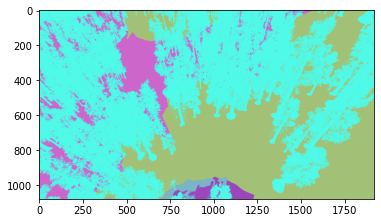

In [16]:
for index, row in gtdf.iterrows():
    timestamp = row.TimeStamp
    print(timestamp)
    if timestamp == 1598288716067:
        print('got it')
        raw_filename, depth_filename, gt_filename = row.ImageFile.split(';')

        gt = cv2.imread(str(source_dir.joinpath(gt_filename)))
plt.imshow(gt)
np.unique(gt.reshape(-1, gt.shape[2]), axis=0, return_counts=True)

In [6]:
file_paths = glob.glob('{}/*.png'.format(src_dir))
img_paths = sorted([path for path in file_paths if '_0_0_' in path])
gt_paths = sorted([path for path in file_paths if '_2_5_' in path])

In [25]:
gt[1000, 1000, :]

array([ 80, 250, 232], dtype=uint8)

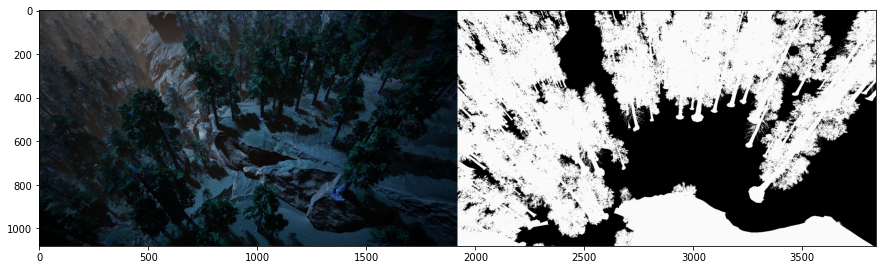

In [29]:
plt.figure(figsize=(15,10))
plt.imshow(combined)